In [1]:
import os 
import glob 
import time
import cv2 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab.patches import cv2_imshow


import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Resnet
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# set seed 
seed = 42 
np.random.seed(seed)
tf.random.set_seed(seed=seed)

In [3]:
# GPU check 
if tf.test.gpu_device_name():
    print('Default GPU device: {}'.format(tf.test.gpu_device_name()))
else: 
    print('Please install GPU for tensorflow')

Default GPU device: /device:GPU:0


In [4]:
# class names 
class_names =  ['COVID', 'NORMAL', 'Viral_Pneumonia']
for i in range(len(class_names)):
    print(class_names[i] ,":" , i)

COVID : 0
NORMAL : 1
Viral_Pneumonia : 2


In [5]:
# image dimension

img = cv2.imread('/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/COVID.png', cv2.IMREAD_UNCHANGED)
 
dimensions = img.shape

height = img.shape[0]
width = img.shape[1]

 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)

Image Dimension    :  (256, 256)
Image Height       :  256
Image Width        :  256


In [6]:
def load_dataset(path): 

  %%time 

  images = []
  labels = []
  data = []

  for dir in os.listdir(path):
    for file_name in tqdm(os.listdir(os.path.join(path, dir))):

      image_path = os.path.join(path, dir, file_name)
      image = load_img(image_path, target_size=(224, 224, 3), color_mode="rgb")
      image = img_to_array(image)
 #     image = np.expand_dims(image, axis=0)
      image /= 255.0

      images.append(image)
      labels.append(dir)


  dataframe = pd.DataFrame({"Images": images, "Label": labels})
  return images, labels, dataframe

In [7]:
path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/images"


images, labels, data = load_dataset(path)

  3%|▎         | 34/1198 [00:00<00:03, 339.22it/s]

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs


100%|██████████| 1344/1344 [00:25<00:00, 53.15it/s]


In [9]:
data.head()

,Images,Label
0,"[[[0.48235294, 0.48235294, 0.48235294], [0.478...",COVID
1,"[[[0.99215686, 0.99215686, 0.99215686], [0.992...",COVID
2,"[[[0.007843138, 0.007843138, 0.007843138], [0....",COVID
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",COVID
4,"[[[0.09019608, 0.09019608, 0.09019608], [0.019...",COVID


In [8]:
# splitting image sets 
X = np.array(images)
y = np.array(data["Label"])


label = LabelEncoder()
y = label.fit_transform(y)



X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)


print("Train shape: {} ----- {} \n  Teste shape: {} ------ {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Train shape: (2716, 224, 224, 3) ----- (2716,) 
  Teste shape: (1165, 224, 224, 3) ------ (1165,)


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2716, 224, 224, 3), (1165, 224, 224, 3), (2716,), (1165,))

In [12]:
# Load dataset 

data_path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/images"


train_dataset = image_dataset_from_directory(directory=data_path,
                                              labels="inferred",
                                              label_mode="int",
                                              class_names=class_names,
                                              color_mode="rgb",
                                              batch_size=32,
                                              image_size=(224, 224),
                                              shuffle=True,
                                              seed=42,
                                              validation_split=0.20,
                                              subset="training",
                                              interpolation="bilinear",
                                              follow_links=False
                                          )



test_dataset = image_dataset_from_directory(directory=data_path,
                                              labels="inferred",
                                              label_mode="int",
                                              class_names=class_names,
                                              color_mode="rgb",
                                              batch_size=32,
                                              image_size=(224, 224),
                                              shuffle=True,
                                              seed=42,
                                              validation_split=0.20,
                                              subset="validation",
                                              interpolation="bilinear",
                                              follow_links=False)

Found 3881 files belonging to 3 classes.
Using 3105 files for training.
Found 3881 files belonging to 3 classes.
Using 776 files for validation.


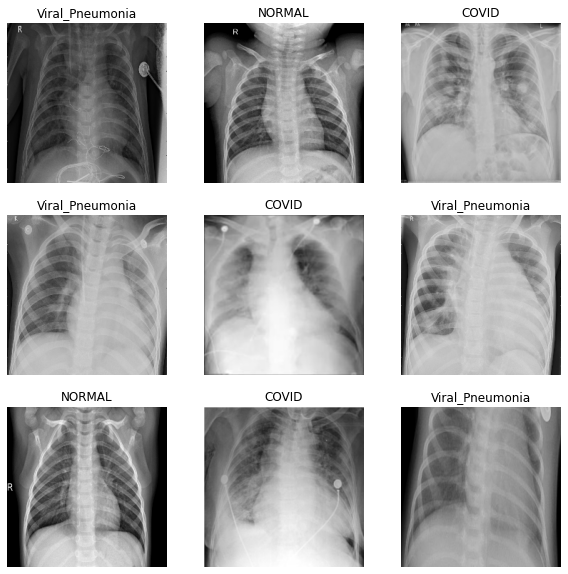

In [13]:
# samples 

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

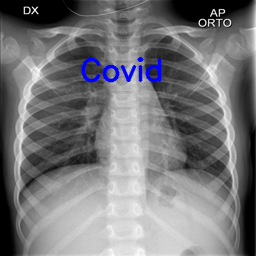

In [14]:
path = '/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/COVID.png'
img = cv2.imread(path)

font=cv2.FONT_HERSHEY_SIMPLEX 
org=(80,80) 
fontScale=1
color=(255, 0, 0) 
thickness=2 
image = cv2.putText(img, 'Covid', org, font, fontScale, color, thickness, cv2.LINE_AA) 

cv2_imshow(image)  

<br>
<hr>
<br>
<br>

#### Convolutional Neural network 

<br>

In [15]:
resnet = ResNet50(include_top=False, input_shape=(224,224,3), classes=3)

In [16]:
# freeze layers
for layers in resnet.layers:
    layers.trainable=False

In [17]:
image = resnet.input
image = preprocess_input(image) # preprocessing image 
input = resnet.output
x = GlobalAveragePooling2D(name="avg_pool")(input)
x = Dense(512, activation='relu')(x)
x = Dropout(0.20)(x)
output_layer = Dense(3, activation="softmax", name="predictions")(x)


model = Model(inputs=resnet.input, outputs=output_layer)

In [18]:
# config network 
model.compile(optimizer=SGD(lr=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


early = EarlyStopping(monitor='val_loss',patience=5)

In [21]:
history = model.fit(X_train, y_train, # normalizing images during train
          batch_size=64,     
          epochs=20,
          validation_data=(X_test, y_test),
          callbacks=[early])

Epoch 1/20
43/43 [==============================] - 12s 274ms/step - loss: 1.1040 - accuracy: 0.3634 - val_loss: 1.0648 - val_accuracy: 0.3270
Epoch 2/20
43/43 [==============================] - 12s 275ms/step - loss: 1.0900 - accuracy: 0.3940 - val_loss: 1.0665 - val_accuracy: 0.3571
Epoch 3/20
43/43 [==============================] - 12s 278ms/step - loss: 1.0897 - accuracy: 0.3833 - val_loss: 1.0579 - val_accuracy: 0.3408
Epoch 4/20
43/43 [==============================] - 12s 280ms/step - loss: 1.0765 - accuracy: 0.4061 - val_loss: 1.0553 - val_accuracy: 0.5167
Epoch 5/20
43/43 [==============================] - 12s 281ms/step - loss: 1.0715 - accuracy: 0.4083 - val_loss: 1.0490 - val_accuracy: 0.7021
Epoch 6/20
43/43 [==============================] - 12s 278ms/step - loss: 1.0709 - accuracy: 0.4091 - val_loss: 1.0517 - val_accuracy: 0.3674
Epoch 7/20
43/43 [==============================] - 12s 277ms/step - loss: 1.0580 - accuracy: 0.4260 - val_loss: 1.0595 - val_accuracy: 0.3811

In [22]:
# save network 
!mkdir -p /content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/last_model
model.save('/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/last_model/resnet_model_last')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/last_model/resnet_model_last/assets


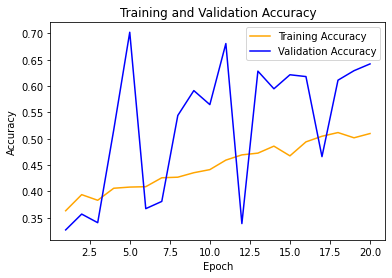

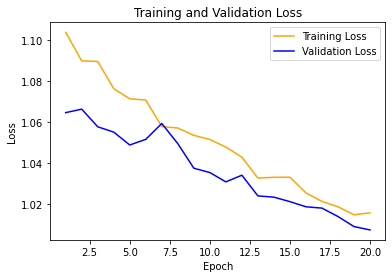

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='orange', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='orange', label='Training Loss')
plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [26]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [29]:
print(classification_report(y_test, y_pred, target_names=label.classes_))

                 precision    recall  f1-score   support

          COVID       0.84      0.64      0.72       387
         NORMAL       0.59      0.98      0.74       397
Viral_Pneumonia       0.54      0.30      0.38       381

       accuracy                           0.64      1165
      macro avg       0.65      0.64      0.61      1165
   weighted avg       0.65      0.64      0.62      1165



<br>
<br>
<hr>
<br>
<br>
<br>
<br>

In [ ]:
def inference(image_path):

    # preprocessing image 
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # prediction 
    y_pred = new_model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)



    if y_pred.any()==0:
      image = load_img(image_path)
      plt.figure(figsize=(8,5))
      plt.imshow(image)
      plt.title("Prediction: Covid-19")
      plt.show()
    elif y_pred.any()==1:
      image = load_img(image_path)
      plt.figure(figsize=(8,5))
      plt.imshow(image)
      plt.title("Prediction: Normal")
      plt.show()
    else: 
      image = load_img(image_path)
      plt.figure(figsize=(8,5))
      plt.imshow(image)
      plt.title("Prediction: Pneumonia")
      plt.show()

In [ ]:
# covid class 
path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/COVID.png"
inference(path)

In [ ]:
# normal class
path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/NORMAL.png"
inference(path)

In [ ]:
# pneumonia class (erro)
path = "/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/inferencia/Viral_Pneumonia.png"
inference(path)

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Deep_Learning_Projetos/case_visao_computacional/lung_diseases/last_model/resnet_model_last')

In [ ]:
image = np.array(load_img(path, target_size=(224, 224, 3)))

In [ ]:
# define layers 
last_conv_layer = new_model.get_layer("conv5_block3_out")
last_conv_layer_model = Model(new_model.inputs, last_conv_layer.output)

In [ ]:
classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["avg_pool", "predictions"]:
    x = new_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [ ]:
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [ ]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
# Average over all the filters to get a single 2D array
gradcam_2 = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam_2 = np.clip(gradcam_2, 0, np.max(gradcam_2)) / np.max(gradcam_2)
gradcam_2 = cv2.resize(gradcam_2, (224, 224))

In [ ]:
# Normal
plt.imshow(image)
plt.imshow(gradcam_2, alpha=0.5, cmap='PuRd') # Plasma